# Convolving ECCO adjoint sensitivities with other fields

Examples loading CMIP5 inter-model spreads and ECCO external forcing data and convolving with ECCO sensitivities.

In [1]:
import xarray as xr
import ecco_v4_py as ecco
import numpy as np
import convolve_fns
import convolve_plots

## 1. Load ECCO sensitivities

First define year(s), basin(s), variable(s) required

In [2]:
ecco_dir = '/gws/nopw/j04/orchestra_vol2/ADJOINT_RESULTS/SO_modewater_8yr_nctiles/' #JASMIN holding location, membership of ORCHESTRA group required for access
years = ['1999'] # 1999-2011 available
#years=[str(x) for x in range(1999,2012)]
basins = ['atl','pac','ind'] # List from ['atl','pac','ind']
ecco_vars=['ADJsaltsurf', 'ADJthetasurf', 'adxx_qnet', 'adxx_tauu', 'adxx_tauv'] # List from ['ADJsaltsurf', 'ADJthetasurf', 'adxx_qnet', 'adxx_tauu', 'adxx_tauv']

In [3]:
ecco_grid=xr.open_dataset('~/encore/convolve/data_in/ECCOv4r3_grid.nc') 

ecco_data=[]
for basin in basins:
    ecco_data_basin=[]
    for year in years:
        adj_sens = xr.open_mfdataset(ecco_dir+year+'/'+basin+'/*[a-zA-Z].nc')
        adj_sens=adj_sens.swap_dims({'time':'lag_years'})
        adj_sens['basin']=(('basin',[basin,]))
        adj_sens['year']=(('year',[year,]))
        ecco_data_basin.append(adj_sens)
    ecco_data.append(xr.concat(ecco_data_basin,'year'))
    
ecco_data=xr.concat(ecco_data,'basin')
if 'adxx_tauu' in ecco_vars:
    ecco_data['adxx_tauu']=-ecco_data['adxx_tauu']
if 'adxx_tauv' in ecco_vars:
    ecco_data['adxx_tauv']=-ecco_data['adxx_tauv']

# Example 1: CMIP5 spread data

Created using CMIP5_ranges notebook, available from https://github.com/emmomp/CMIP5_spreads

### 1.1. Define map between CMIP and ECCO variables and load the data

In [4]:
cmip_ecco_map={'ADJthetasurf':['tos_std','tos_spread'],'ADJsaltsurf':['sos_std',],'adxx_qnet':['hfds_std',],'adxx_tauu':['tauuo_std',],'adxx_tauv':['tauvo_std',]}
cmip_dir='~/encore/cmip/data_out'
cmip_vars=['tos','sos','hfds','tauuo','tauvo']

def pre_proc(ds):
    fname=ds.encoding["source"]
    var=fname.split('_')[-2]
    ds=ds.rename_vars({'model_std':'{}_std'.format(var),'model_spread':'{}_spread'.format(var)})
    return ds

cmip_spreads=xr.open_mfdataset(cmip_dir+'/cmip5_stdspread_*_model.nc',preprocess=pre_proc)

### 1.2. Perform the convolution

Provide optional input 'dir_out' to have convolutions written to file

In [5]:
cmip5_out=convolve_fns.convolve_ecco(np.abs(ecco_data),cmip_spreads.mean(dim='time'),cmip_ecco_map,ecco_grid)

ADJthetasurf atl 1999
ADJthetasurf pac 1999
ADJthetasurf ind 1999
ADJsaltsurf atl 1999
ADJsaltsurf pac 1999
ADJsaltsurf ind 1999
adxx_qnet atl 1999
adxx_qnet pac 1999
adxx_qnet ind 1999
adxx_tauu atl 1999
adxx_tauu pac 1999
adxx_tauu ind 1999
adxx_tauv atl 1999
adxx_tauv pac 1999
adxx_tauv ind 1999


## Example 2: CMIP6 spread data

Created using CMIP6_ranges notebook, available from https://github.com/emmomp/CMIP6_spreads

### 2.1. Define map between CMIP and ECCO variables and load the data

In [6]:
cmip_ecco_map={'ADJthetasurf':['tos_std','tos_spread'],'ADJsaltsurf':['sos_std',],'adxx_qnet':['hfds_std',],'adxx_tauu':['tauuo_std',],'adxx_tauv':['tauvo_std',]}
cmip_dir='/home/users/eboland/encore/cmip/data_out'
cmip_vars=['tos','sos','hfds','tauuo','tauvo']

def pre_proc(ds):
    fname=ds.encoding["source"]
    var=fname.split('_')[-2]
    ds=ds.rename_vars({'model_std':'{}_std'.format(var),'model_spread':'{}_spread'.format(var)})
    return ds

cmip6_spreads=xr.open_mfdataset(cmip_dir+'/cmip6_stdspread_*_model.nc',preprocess=pre_proc)

In [7]:
cmip6_out=convolve_fns.convolve_ecco(np.abs(ecco_data),cmip6_spreads,cmip_ecco_map,ecco_grid)

ADJthetasurf atl 1999
ADJthetasurf pac 1999
ADJthetasurf ind 1999
ADJsaltsurf atl 1999
ADJsaltsurf pac 1999
ADJsaltsurf ind 1999
adxx_qnet atl 1999
adxx_qnet pac 1999
adxx_qnet ind 1999
adxx_tauu atl 1999
adxx_tauu pac 1999
adxx_tauu ind 1999
adxx_tauv atl 1999
adxx_tauv pac 1999
adxx_tauv ind 1999


## Example 3: ECCO forcing data

### 3.1. Define map between adjoint and forcing variables, and load the data

In [8]:
exf_vars=['THETA','SALT','EXFqnet','EXFtaue','EXFtaun']
# Create weights for Southern Ocean mean
somask=(ecco_grid.YC<-25) & (ecco_grid.YC>=-65)
weight=somask*ecco_grid.rA*ecco_grid.hFacC.isel(k=0)

# Load data for 3D standard deviations, calculating domain mean too
ecco_exf_data=[]
for var in exf_vars:    
    if var in ['THETA','SALT']: #3D variables
        sig3d=ecco.read_llc_to_tiles('/home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms',var+'.bin',use_xmitgcm=True,nk=50)
        sig3dsurf=sig3d[0,0,:,:,:] 
        sig3d_ds=xr.DataArray(data=sig3dsurf,dims=['tile','j','i'],name=var+'surf')        
    else:
        sig3d=ecco.read_llc_to_tiles('/home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms',var+'.bin',use_xmitgcm=True)
        sig3d_ds=xr.DataArray(data=sig3d.squeeze(),dims=['tile','j','i'],name=var)
    sig0_ds=sig3d_ds.weighted(weight).mean()
    sig0_ds=sig0_ds.rename(sig3d_ds.name+'0')
    # Rename to align with ECCO adjoint grid output
    if var=='EXFtaue':
        sig3d_ds=sig3d_ds.rename({'i':'i_g'})
    elif var=='EXFtaun':
        sig3d_ds=sig3d_ds.rename({'j':'j_g'})
    ecco_exf_data.append(sig3d_ds)
    ecco_exf_data.append(sig0_ds)
ecco_exf_data=xr.merge(ecco_exf_data)

ecco3d_ecco_map={'ADJthetasurf':['THETAsurf','THETAsurf0'],'ADJsaltsurf':['SALTsurf','SALTsurf0'],'adxx_qnet':['EXFqnet','EXFqnet0'],
                 'adxx_tauu':['EXFtaue','EXFtaue0'],'adxx_tauv':['EXFtaun','EXFtaun0']}

read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/THETA.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/SALT.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/EXFqnet.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/EXFtaue.bin
read_llc_to_tiles: full_filename:  /home/users/eboland/encore/convolve/data_in/ecco_stdvs_anoms/EXFtaun.bin


### 3.2. Perform the convolution

In [9]:
eccoexf_out=convolve_fns.convolve_ecco(ecco_data,ecco_exf_data,ecco3d_ecco_map,regrid=False)

ADJthetasurf atl 1999
ADJthetasurf pac 1999
ADJthetasurf ind 1999
ADJsaltsurf atl 1999
ADJsaltsurf pac 1999
ADJsaltsurf ind 1999
adxx_qnet atl 1999
adxx_qnet pac 1999
adxx_qnet ind 1999
adxx_tauu atl 1999
adxx_tauu pac 1999
adxx_tauu ind 1999
adxx_tauv atl 1999
adxx_tauv pac 1999
adxx_tauv ind 1999


### Make some plots

### P.1. Plot time series for all variables and basins

/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/sit

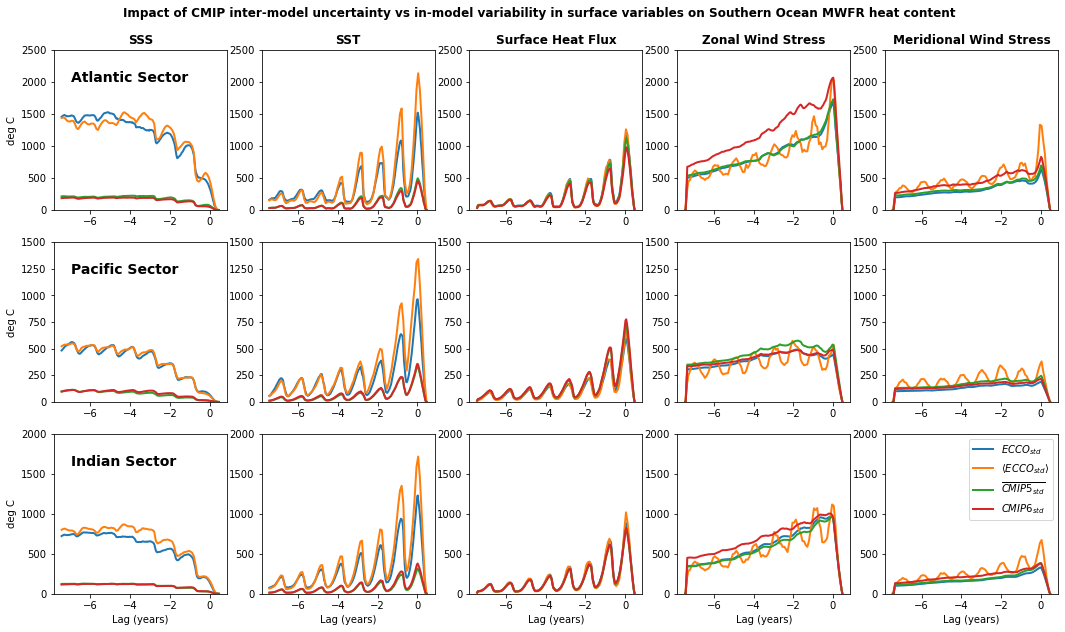

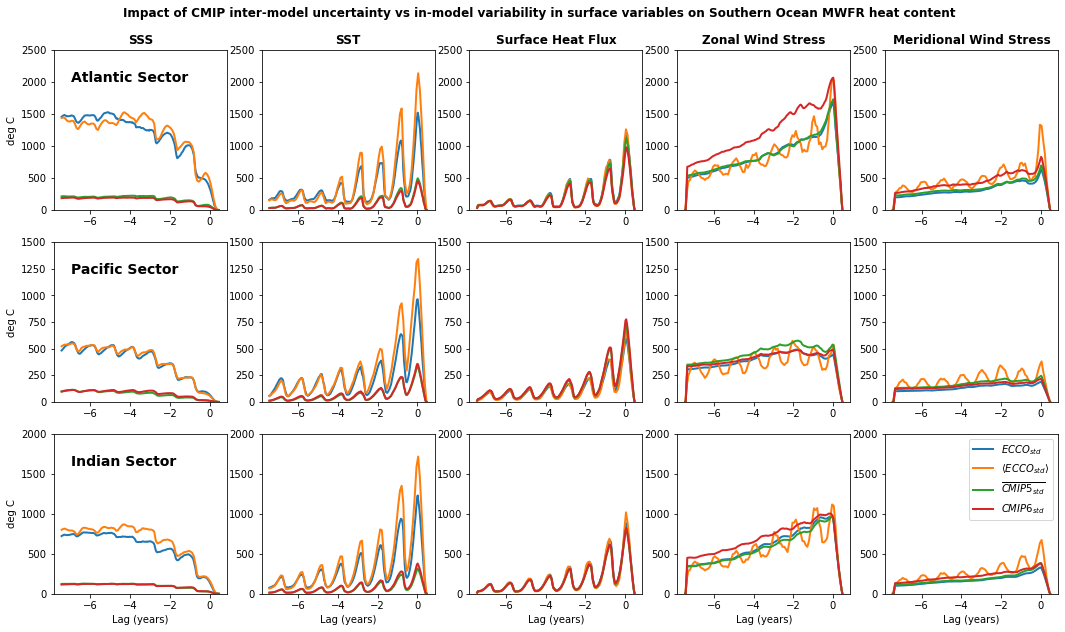

In [15]:
plots_dir='./'
convolve_plots.timeseries_plot({'cmip5':cmip5_out,'cmip6':cmip6_out,'eccoexf':eccoexf_out},cmip_ecco_map,ecco3d_ecco_map,plots_dir)    

### P.2. Look at spatial distributions at lag of peak SST impact in Pacific sector

In [ ]:
# Choose variable and basin
var='ADJthetasurf'
basin='pac'
convolve_plots.spatial_plot(var,basin,{'eccoexf':eccoexf_out,'cmip5':cmip5_out,'cmip6':cmip6_out},ecco_exf_data,cmip_spreads,
                            cmip6_spreads,cmip_ecco_map,ecco3d_ecco_map,ecco_grid,plots_dir,clims=[0,1.5]) 

/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-179.5 19.5
-180.0 20.0
-89.5 89.5
-90.0 90.0
20.50315462264151 179.4968553773585
20.00001 180.0
-89.5 89.5
-90.0 90.0


/home/users/eboland/.conda/envs/nbenvconda/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


-179.5 19.5
-180.0 20.0
-89.5 89.5
-90.0 90.0


### Convert to python script 

In [1]:
!jupyter nbconvert --to script convolve_examples.ipynb

[NbConvertApp] Converting notebook convolve_examples.ipynb to script
[NbConvertApp] Writing 18472 bytes to convolve_examples.py
Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-nbconvert", line 11, in <module>
    sys.exit(main())
  File "/home/users/eboland/.local/lib/python3.7/site-packages/jupyter_core/application.py", line 270, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/nbconvert/nbconvertapp.py", line 346, in start
    self.convert_notebooks()
  File "/opt/conda/lib/python3.7/site-packages/nbconvert/nbconvertapp.py", line 518, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/opt/conda/lib/python3.7/site-packages/nbconvert/nbconvertapp.py", line 484, in convert_single_notebook
    write_results = self.write_single_no